In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling, RandomZoom
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Set the path to the split dataset directory
split_dataset_dir = '/content/drive/MyDrive/Dataset_divided'


In [ ]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
])




In [ ]:

# Load data with consistent normalization and get labels for training
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_dataset_dir, 'train'),
    seed=1,
    image_size=(128, 128),
    batch_size=32,
).map(lambda x, y: (data_augmentation(x, training=True), y))
import numpy as np


# Load data with consistent normalization for validation
X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_dataset_dir, 'valid'),
    seed=1,
    image_size=(128, 128),
    batch_size=32,
).map(lambda x, y: (data_augmentation(x, training=False), y))


Found 7350 files belonging to 4 classes.
Found 1578 files belonging to 4 classes.


In [ ]:
# Preprocess the data
AUTOTUNE = tf.data.AUTOTUNE
X_train = X_train.prefetch(buffer_size=AUTOTUNE)
X_validation = X_validation.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increase patience
    restore_best_weights=True
)


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Xception model with Batch Normalization and Dropout
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Additional Dense layer with regularization
    BatchNormalization(),
    Dropout(0.6),  # Increase dropout rate
    Dense(4, activation='softmax')
])

# Learning Rate Scheduler Adjustment
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,  # Reduced initial learning rate
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

# Specify the path and filename for saving the model
model_save_path = '/content/drive/MyDrive/saved_model/Xception_Model.h5'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]

# Data Augmentation Configuration
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])



83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_5 (Bat  (None, 128)              

In [ ]:
# Model Training
history = model.fit(
    X_train,
    epochs=100,
    validation_data=X_validation,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
230/230 [==============================] - 2880s 12s/step - loss: 5.4022 - accuracy: 0.3465 - val_loss: 4.6527 - val_accuracy: 0.5000
Epoch 2/100
230/230 [==============================] - 56s 238ms/step - loss: 4.2420 - accuracy: 0.4673 - val_loss: 3.6494 - val_accuracy: 0.5311
Epoch 3/100
230/230 [==============================] - 55s 234ms/step - loss: 3.5015 - accuracy: 0.5046 - val_loss: 4.1135 - val_accuracy: 0.5089
Epoch 4/100
230/230 [==============================] - 55s 236ms/step - loss: 2.7759 - accuracy: 0.5799 - val_loss: 2.6007 - val_accuracy: 0.5583
Epoch 5/100
230/230 [==============================] - 55s 233ms/step - loss: 2.2315 - accuracy: 0.6314 - val_loss: 2.1241 - val_accuracy: 0.5520
Epoch 6/100
230/230 [==============================] - 55s 235ms/step - loss: 1.7971 - accuracy: 0.6605 - val_loss: 1.6631 - val_accuracy: 0.6413
Epoch 7/100
230/230 [==============================] - 56s 238ms/step - loss: 1.4711 - accuracy: 0.6744 - val_loss: 1.2340 -

In [ ]:

# Save the entire model to a HDF5 file
model.save('/content/drive/MyDrive/saved_model/Xception_Model.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model from the HDF5 file
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Xception_Model.h5')


In [ ]:
# Save the entire model to Google Drive
loaded_model.save('/content/drive/MyDrive/saved_model/Xception_Model.h5')

In [ ]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

50/50 [==============================] - 6s 106ms/step - loss: 0.1695 - accuracy: 0.9468
Accuracy: % 94.68
Loss: % 16.95


In [ ]:

# Save the updated model with the same name
loaded_model.save('/content/drive/MyDrive/saved_model/Xception_Model.h5')

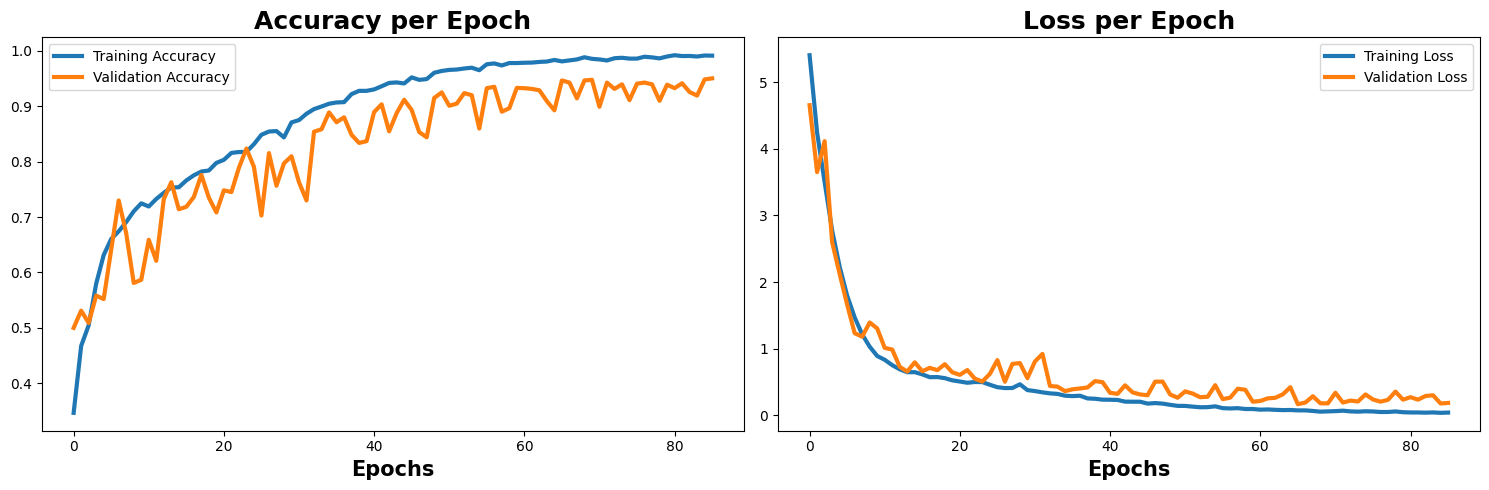

In [ ]:
df = pd.DataFrame(history.history)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(df['accuracy'], label='Training Accuracy', lw=3)
ax1.plot(df['val_accuracy'], label='Validation Accuracy', lw=3)
ax1.set_title('Accuracy per Epoch', fontsize=18, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax1.legend()

# Plot loss
ax2.plot(df['loss'], label='Training Loss', lw=3)
ax2.plot(df['val_loss'], label='Validation Loss', lw=3)
ax2.set_title('Loss per Epoch', fontsize=18, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

[]

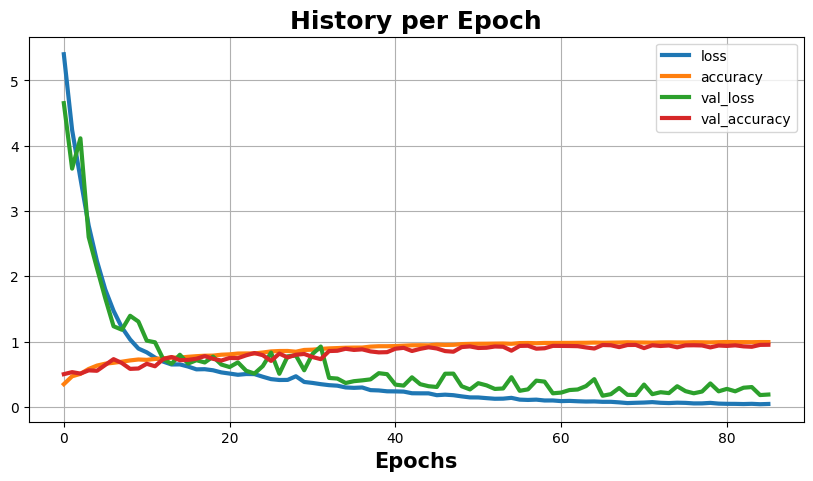

In [ ]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import pandas as pd
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [ ]:
# Save the entire model to Google Drive
loaded_model.save('/content/drive/MyDrive/saved_model/Xception_Model.h5')

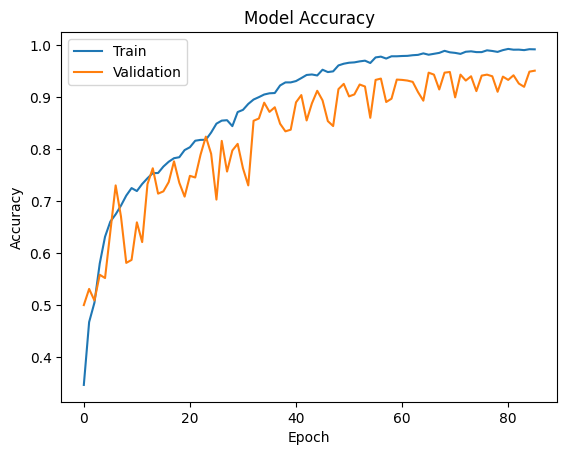

In [ ]:
#model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Xception_Model.h5')

# Visualize Training History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the entire model to a HDF5 file
loaded_model.save('/content/drive/MyDrive/saved_model/Xception_Model.h5')


Found 1574 files belonging to 4 classes.
Total samples in the test dataset: 1574
1/1 [==============================] - 1s 803ms/step
Accuracy: 94.09%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


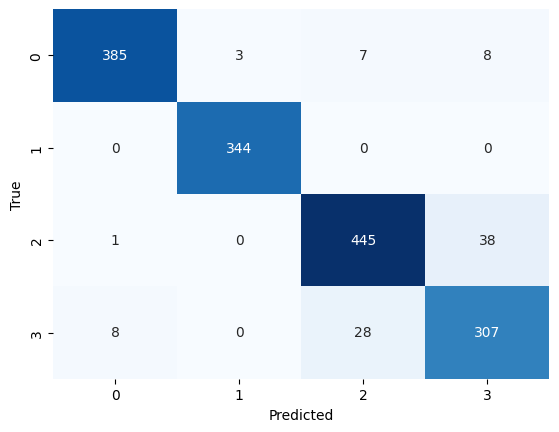

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


# Load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Xception_Model.h5')

# Set the path to the split dataset directory
split_dataset_dir = '/content/drive/MyDrive/Dataset_divided'

# Load the test dataset
test_data_dir = os.path.join(split_dataset_dir, 'test')
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=1,
    image_size=(128, 128),
    batch_size=32
)

total_samples = 0
for images, labels in X_test:
    total_samples += len(labels)
print("Total samples in the test dataset:", total_samples)

# Make predictions on the test dataset
y_true = []
y_pred = []
for images, labels in X_test:
    predictions = loaded_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert true and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()






In [8]:
# Save the updated model with the same name
loaded_model.save('/content/drive/MyDrive/saved_model/Xception_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
